<a href="https://colab.research.google.com/github/HarrisonGrubb/python-business-analytics/blob/master/Credit_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading In Packages to Get Set Up

In [ ]:
%%capture 
# install packages
!pip install dtreeviz

In [ ]:
## Read in packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Links
# https://www.kaggle.com/bpkapkar/credit-card-consumption-prediction?select=train+and+test+data.csv
# https://www.kaggle.com/brycecf/give-me-some-credit-dataset?select=cs-training.csv
# https://loanperformancedata.fanniemae.com/lppub/index.html?_ga=2.106516929.311135568.1606702564-935927403.1606702564#

# https://github.com/parrt/dtreeviz
# https://h1ros.github.io/posts/how-to-visualize-a-decision-tree-beyond-scikit-learn/

# Reading in the data and exploring variables

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Kaggle Contest Data/Credit Data/credit training data.csv')

In [ ]:
data = data.drop(columns=['Unnamed: 0'], axis=1)
data.head()


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
def nan_check (data, col_list):
  nan_col_to_check = []
  for column in col_list:
    if pd.notna(data[column]).all() == True:
      pass
    else:
      nan_col_to_check.append(column)
  return nan_col_to_check

def null_check (data, col_list):
  null_col_to_check = []
  for column in col_list:
    if pd.notnull(data[column]).all() == True:
      pass
    else:
      null_col_to_check.append(column)
  return null_col_to_check

In [ ]:
nan_check(data,data.columns)

['MonthlyIncome', 'NumberOfDependents']

In [ ]:
data = data.dropna(axis=0)

In [ ]:
pair_plot_subset = data
pair_plot_subset = pair_plot_subset.drop(labels=['SeriousDlqin2yrs', 
                                                 'age',  
                                                 'NumberOfTime30-59DaysPastDueNotWorse',
                                                 'DebtRatio'
                                                 ], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f245baa1c88>,
      dtype=object)

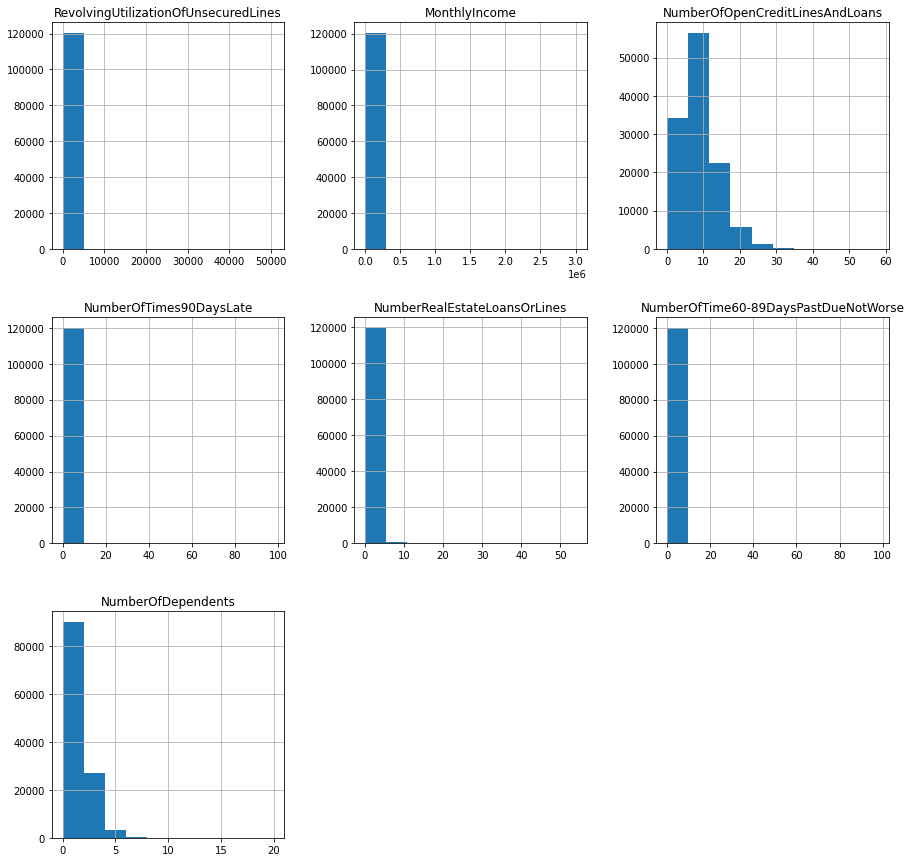

In [ ]:
pair_plot_subset.hist(figsize=(15,15))

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


IndexError: ignored

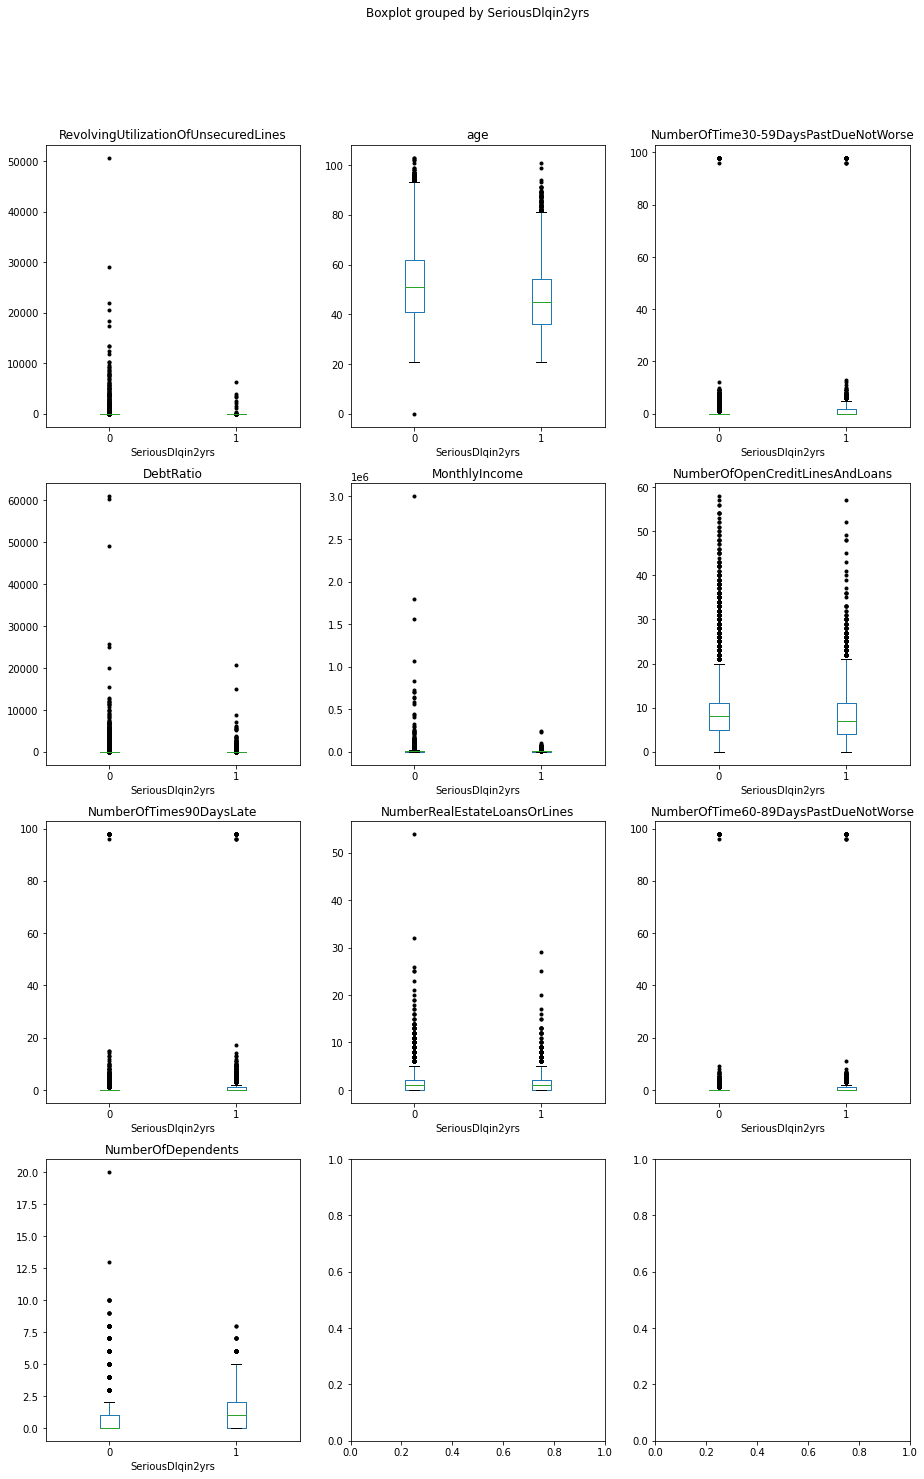

In [ ]:
columns = data.columns
columns = columns.drop(labels='SeriousDlqin2yrs')
print(columns)
rows = 4
cols = 3
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(5*cols, 6*rows))
axs = axs.flatten()
for i in range(len(data.columns)):
  data.boxplot(columns[i], by='SeriousDlqin2yrs', grid=False, ax=axs[i], sym='k.')

# Predicting who will have a credit event

In [ ]:
Y = data.SeriousDlqin2yrs
X = data
X = X.drop(columns = ['SeriousDlqin2yrs'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Log model to understand variable importance

In [ ]:
log = LogisticRegression()

In [ ]:
stat_log = sm.Logit(Y_train, X_train)

In [ ]:
stat_results = stat_log.fit(disp=0)
print('Parameters: ', stat_results.params)

Parameters:  RevolvingUtilizationOfUnsecuredLines   -0.000059
age                                    -0.051382
NumberOfTime30-59DaysPastDueNotWorse    0.484782
DebtRatio                              -0.000176
MonthlyIncome                          -0.000050
NumberOfOpenCreditLinesAndLoans        -0.018917
NumberOfTimes90DaysLate                 0.394635
NumberRealEstateLoansOrLines            0.111715
NumberOfTime60-89DaysPastDueNotWorse   -0.846425
NumberOfDependents                      0.044048
dtype: float64


In [ ]:
print(stat_results.summary())

                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:                96215
Model:                          Logit   Df Residuals:                    96205
Method:                           MLE   Df Model:                            9
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:                 0.05938
Time:                        20:16:13   Log-Likelihood:                -22816.
converged:                       True   LL-Null:                       -24256.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
RevolvingUtilizationOfUnsecuredLines -5.906e-05   7.93e-05     -0.745      0.457      -0.000    9.64e-05
age                                     -0.0514      

## Log model complexity control and AUC scores

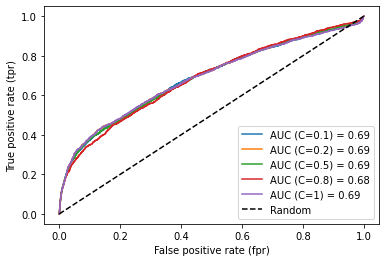

In [ ]:
params = [0.1, 0.2, 0.5, 0.8,1]

for c in params:
  model = LogisticRegression(C=c, solver='liblinear')
  model.fit(X_train, Y_train)

  # Get the probability of Y_test records being = 1
  Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

  # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
  fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
  
  # Get the area under the curve (AUC)
  auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))

  # Plot the ROC curve
  plt.plot(fpr, tpr, label="AUC (C=" + str(c) + ") = " + str(round(auc, 2)))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')
Feature: 0, Score: -0.00004
Feature: 1, Score: -0.02805
Feature: 2, Score: 0.47971
Feature: 3, Score: -0.00012
Feature: 4, Score: -0.00004
Feature: 5, Score: -0.00530
Feature: 6, Score: 0.39846
Feature: 7, Score: 0.07008
Feature: 8, Score: -0.84131
Feature: 9, Score: 0.10431


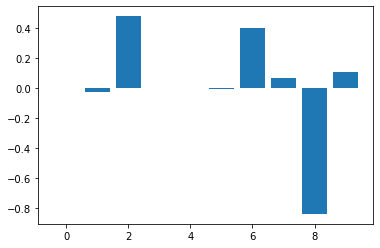

In [ ]:
importance = model.coef_[0]
# summarize feature importance
print(X.columns)
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Decision Tree approach

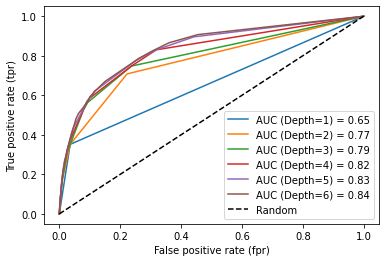

In [ ]:
depth = [1, 2, 3, 4, 5, 6]

for level in depth:
  model = DecisionTreeClassifier(min_samples_leaf= 150, max_depth=level)
  model.fit(X_train, Y_train)

  # Get the probability of Y_test records being = 1
  Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

  # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
  fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
  
  # Get the area under the curve (AUC)
  auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))

  # Plot the ROC curve
  plt.plot(fpr, tpr, label="AUC (Depth=" + str(level) + ") = " + str(round(auc, 2)))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

In [ ]:
model_tree = DecisionTreeClassifier(min_samples_leaf=150, max_depth=4)
model_tree.fit(X_train, Y_train)
feature_list = X_train.columns

In [ ]:
print(feature_list)

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


In [ ]:
viz = dtreeviz(model_tree, X_train, Y_train, np.array(feature_list), class_names={0 : 'No_Bankrupt', 1: 'Bankrupt'})

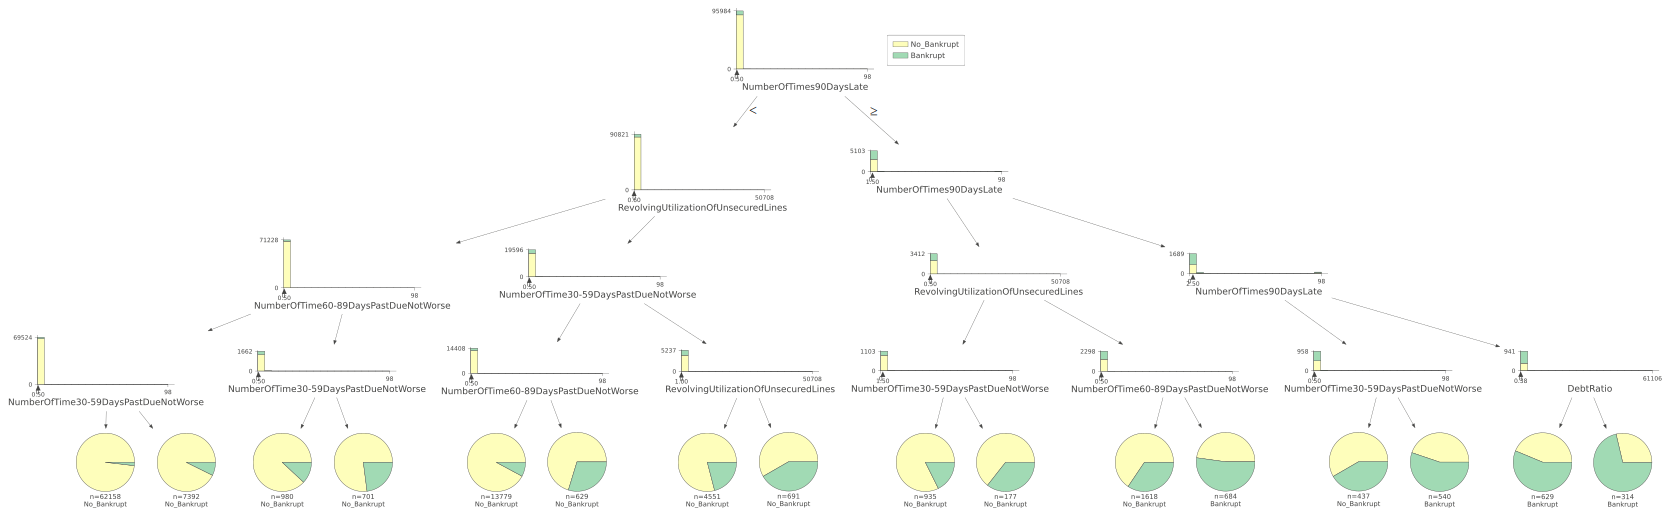

In [ ]:
viz